<a href="https://colab.research.google.com/github/AyaAhmed01/Machine-Learning-Projects/blob/main/Devices_Price_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
# For ML models

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# For Data Processing
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from google.colab import files

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
data_files = files.upload()

Saving train - train.csv to train - train (1).csv
Saving test - test.csv to test - test (1).csv


In [58]:
train_df = pd.read_csv('train - train.csv')
test_df = pd.read_csv('test - test.csv')

In [59]:
num_rows_with_null = train_df.isnull().any(axis=1).sum()
print("Number of rows with at least one null value:", num_rows_with_null)

Number of rows with at least one null value: 9


In [60]:
# number of missing data records is small and can be dropped
train_df.dropna(inplace= True)

In [61]:
train_df.describe()[1:].T.style.background_gradient(cmap='Blues')

,mean,std,min,25%,50%,75%,max
battery_power,1238.270718,439.641057,501.000000,851.500000,1225.000000,1615.500000,1998.000000
blue,0.496233,0.500111,0.000000,0.000000,0.000000,1.000000,1.000000
clock_speed,1.522451,0.815499,0.500000,0.700000,1.500000,2.200000,3.000000
dual_sim,0.510799,0.500009,0.000000,0.000000,1.000000,1.000000,1.000000
fc,4.307885,4.339735,0.000000,1.000000,3.000000,7.000000,19.000000
four_g,0.520844,0.499691,0.000000,0.000000,1.000000,1.000000,1.000000
int_memory,32.074335,18.138177,2.000000,16.000000,32.000000,48.000000,64.000000
m_dep,0.502009,0.288622,0.100000,0.200000,0.500000,0.800000,1.000000
mobile_wt,140.263184,35.398777,80.000000,109.000000,141.000000,170.000000,200.000000
n_cores,4.516323,2.291257,1.000000,3.000000,4.000000,7.000000,8.000000


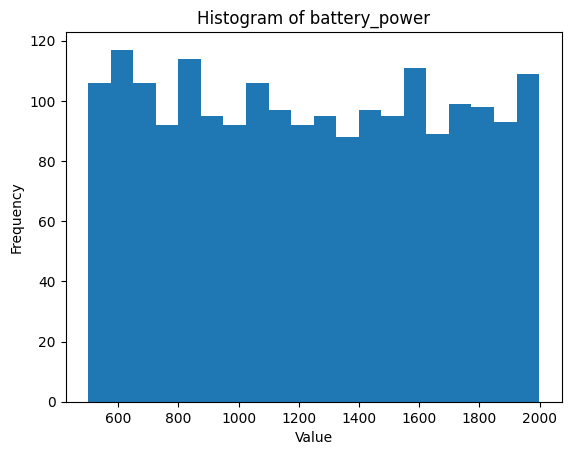

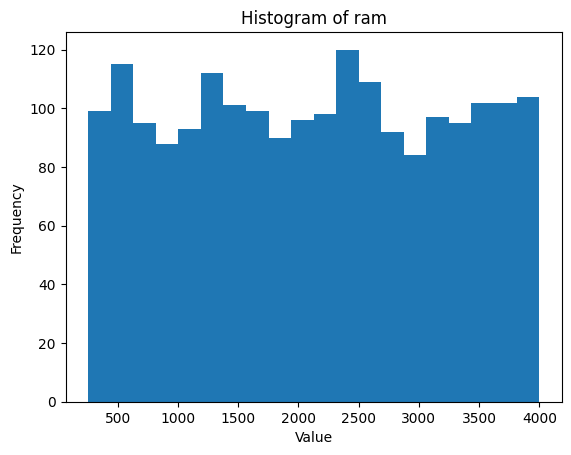

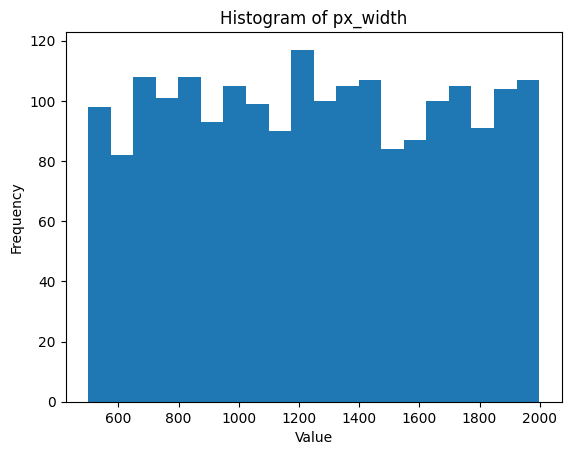

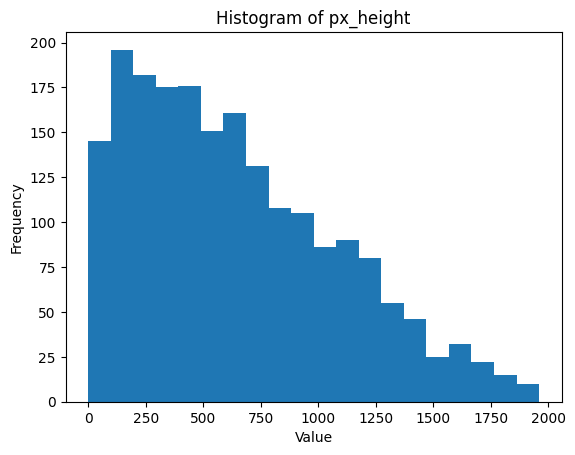

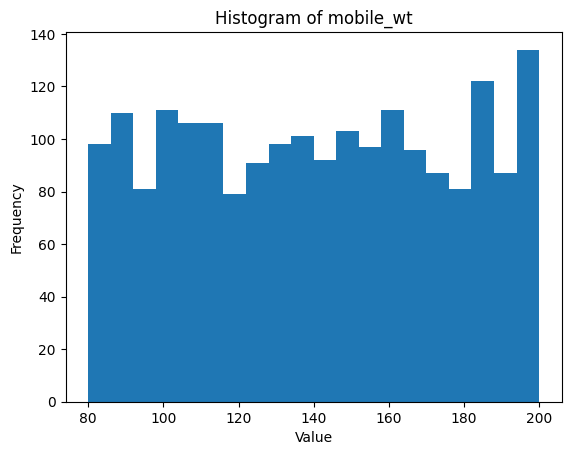

In [62]:
for column in train_df[['battery_power', 'ram', 'px_width', 'px_height', 'mobile_wt']]:
    # Plot histogram for each column
    plt.hist(train_df[column], bins=20)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(column))
    plt.show()

- Although the std of some colums is high, the percentile values (e.g., 50%, 25%) and histograms dosen't show serious abnormalities or skewed data except for the px_height colum that needs to be normalized

In [63]:
# making log transformation to reduce distribution skewness
from scipy.stats import boxcox
train_df['px_height'], _ = boxcox(train_df['px_height'] + 1)

Text(0.5, 1.0, 'Histogram of px_height')

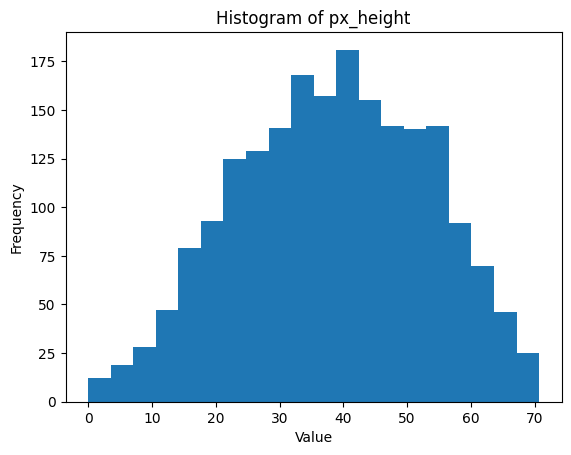

In [64]:
plt.hist(train_df['px_height'], bins=20)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of px_height')

In [65]:
train_df['px_height'].describe()  # reduced the std from 443 to 14

count    1991.000000
mean       38.360799
std        14.824406
min         0.000000
25%        27.517085
50%        38.721289
75%        49.842959
max        70.710301
Name: px_height, dtype: float64

In [66]:
# Correlation Matrix
fig = px.imshow(train_df.corr(),color_continuous_scale="Blues")
fig.update_layout()
fig.show()

For more simplification of model, improving prediction and reducing overfitting, dropped the features with very low correlation (< 0.01) with the output.

In [67]:
labels = ['clock_speed', 'm_dep', 'n_cores']
train_df.drop(columns = labels, inplace= True)

In [68]:
y_train = train_df['price_range']
del train_df['price_range']

In [69]:
x_train, x_test, y_train, y_test = train_test_split(train_df, y_train, test_size=0.2, random_state=42)

In [70]:
# Initialize and train logistic regression model for multiclass classification
def train(x_train, y_train, x_test):
  model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
  model.fit(x_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(x_test)
  return y_pred

# Calculate accuracy score
y_pred = train(x_train, y_train, x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy without optimization:", accuracy)      # model achieving overall low accuracy of 63.6%

Test Accuracy without optimization: 0.6365914786967418


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [71]:
from sklearn.preprocessing import StandardScaler
# Enhance accuracy:
# Since features have different scales, it's difficult to converge and features with larger scales or variances (such as 'ram' feature) dominate the learning algorithm
# standardize them to ensure that all features contribute equally.

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

y_pred = train(x_train_scaled, y_train, x_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("Test Accuracy after scaling:", accuracy)      # model achieving overall high accuracy of 96%

Test Accuracy after scaling: 0.9598997493734336


<Axes: >

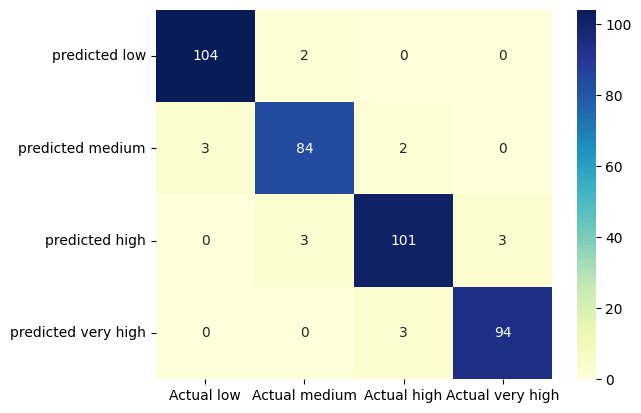

In [72]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual low', 'Actual medium', 'Actual high', 'Actual very high'],
                                 index=['predicted low', 'predicted medium', 'predicted high', 'predicted very high'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

- As illustrated from the cofusion matrix that the model has high prediction accuracy specially on low and very high classes